In [1]:
from importlib import reload
import platform, os, sys, datetime, re
import multiprocessing
from os.path import join
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# sys.path.append(join(root_dir,'cvtracer'))
import cvt
from cvt.TrAQ.Trial import Trial
from cvt.TrAQ.Tank import Tank
from cvt.TrAQ.CVTracer import CVTracer, create_named_window, wait_on_named_window
from cvt.utils import *

default_settings = dict(
    t_start        = 0,     # Time at which to start tracking, in seconds.
    t_end          = -1,    # Time at which to end tracking, in seconds.
    
    # Contour detection.
    n_pixel_blur   =  7,    # square-root of n-pixels for threshold blurring
    block_size     = 15,    # contour block size
    thresh_offset  = 15,    # threshold offset for contour-finding
    min_area       = 25,    # minimum area for threhold detection
    max_area       = 60,    # maximum area for threhold detection
    RGB            = False, # track in color, false does greyscale
    online_viewer  = False, # Toggle live preview of tracking.

    # Background subtraction (for naive background subtraction only).
    bkgSub_options = dict( n_training_frames = 100, # number of frames used to compute background
                           t_start = 0, t_end = -1, # time range used to compute background
                           contrast_factor = 4 ),   # post-subtraction contrast enhancement factor
    
    # What information to draw on the tracking output video.
    video_output_options = dict(tank=True, repeat_contours=False, all_contours=True, 
                                contour_color=(0,200,255), contour_thickness=1, 
                                points=False, directors=True, timestamp=True)
    )

def create_settings_(input_file, tracking_dir, settings):
    
    globals().update(settings)
    tank_diameter_vs_age = { 7:9.6, 14:10.4, 21:12.8, 28:17.7, 42:33.8 }
    
    ''' Extract trial info from the filename and the video itself. '''

    filename,ext = os.path.splitext(os.path.basename(input_file))
    pop,_,age,group,Nfish = filename.split('_')[:5]
    Nfish    = int(re.findall('\d+',Nfish)[0])
    age      = int(age[:-3])
    tank_radius = tank_diameter_vs_age[age]/2

    cap      = cv2.VideoCapture(input_file)
    cap.read()
    Nframes  = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps      = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc   = int(cap.get(cv2.CAP_PROP_FOURCC))
    width    = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    
    ''' Define and create necessary folders/files/links. '''
    
    output_dir = join(tracking_dir,filename)

    new_input_file = input_file
    if not 'windows' in platform.system().lower():
        new_input_file = join(output_dir,'raw'+ext)
    
    settings_file = join(output_dir,'tracking_settings.txt')
    trial_file    = join(output_dir,'trial.pik')
    tank_file     = join(output_dir,'tank.pik')
    n_bkg         = bkgSub_options['n_training_frames']
    bkg_file      = join(output_dir,f'background-{n_bkg}.npz')
    
    for k,v in locals().items():
        if k not in ['cap','settings','tank_diameter_vs_age','_','n_bkg']:
            settings[k] = v
        
    return settings


def create_directories(settings):
    for k in 'tracking_dir','output_dir','input_file','new_input_file':
        globals()[k] = settings[k]
    if not os.path.exists(tracking_dir):
        os.mkdir(tracking_dir)
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    if not 'windows' in platform.system().lower():
        if not os.path.exists(new_input_file):
            os.symlink(os.path.relpath(input_file,output_dir),new_input_file)
    return


def save_settings(settings):
    with open(settings['settings_file'],'w') as fh:
        for k,v in settings.items():
            print(f'{k} = {v}',file=fh)
    return

# Locate input/output and allocate CPU's

`tracking_dir` sets the top-level output directory. The output of tracking each video will go in `tracking_dir`, in a subdirectory named after the input video file.  

`n_threads` controls the number of tracking tasks to execute simulataneously. `n_threads = None` defaults to the number of CPU's on the machine running the notebook. **This feature doesn't work in Windows, if you're using Windows

`input_files` set the list of video files to perform tracking on.

In [22]:
# tracking_dir = '../tracking/full' # use this one to track full videos
# tracking_dir = '../tracking/partial' # use this one to track small excerpts
tracking_dir = '../tracking/test'

def create_settings(input_file,tracking_dir=tracking_dir,settings=default_settings):
    return create_settings_(input_file,tracking_dir,settings)

#-----------------------------

n_threads = None
# Multi-threading doesn't work in Windows. If the OS is Windows, multi-threading doesn't work, set n_thread to 1.
if 'windows' in platform.system().lower():
    n_threads = 1

#-----------------------------

# input_files = sorted(glob('../raw_videos/*.avi'))
input_files = sorted(glob('../raw_videos/Pa_Fri_7dpf_GroupB_*.avi'))

# input_files = []
# for f in sorted(glob('../raw_videos/*.avi')):
#     print(f)
#     settings = create_settings(f)
#     if not os.path.exists(settings['trial_file']):
#         input_files.append(f)
# display(input_files)

# input_files = sorted(glob('./test/input/*.avi'))

display(input_files)
input_files = [ input_files[0] ]

['../raw_videos/Pa_Fri_7dpf_GroupB_n2b_2020-06-05-114635-0000.avi',
 '../raw_videos/Pa_Fri_7dpf_GroupB_n5_2020-06-05-094643-0000.avi']

# Locate the tanks

In [23]:
for input_file in input_files:
    print(input_file)
    settings = create_settings(input_file)
    create_directories(settings)
    globals().update(settings)
    tank = Tank(r_cm=tank_radius)
    tank.load_or_locate_and_save(tank_file,input_file)

../raw_videos/Pa_Fri_7dpf_GroupB_n2b_2020-06-05-114635-0000.avi

       Tank not found ./test/output/Pa_Fri_7dpf_GroupB_n2b_2020-06-05-114635-0000/tank.pik 
    Locating tank edges... 

       Tank detection complete.


# Track

In [24]:
display(input_files)

['../raw_videos/Pa_Fri_7dpf_GroupB_n2b_2020-06-05-114635-0000.avi']

In [26]:
reload(cvt.TrAQ.Trial)
from cvt.TrAQ.Trial import Trial
reload(cvt.TrAQ.CVTracer)
from cvt.TrAQ.CVTracer import CVTracer, create_named_window, wait_on_named_window


# tweaks = dict(t_start = 4, t_end = 5,
tweaks = dict(t_start = 60, t_end = 90,
              n_pixel_blur   =  5,    # square-root of n-pixels for threshold blurring
              block_size     = 15,    # contour block size
              thresh_offset  = 13,    # threshold offset for contour-finding
              min_area       = 15,    # minimum area for threhold detection
              max_area       = 100,   # maximum area for threhold detection
              online_viewer  = False, 
              video_output_options = dict( tank = False, repeat_contours = False, all_contours = True, 
                                           contour_color = (0,0,255), contour_thickness = 1, 
                                           points = False, timestamp = True ),
                                           # Note: There's no point drawing the tank since we're masking
                                           # everything outside the tank anyway.
             )


def track(input_file):
    
    print(input_file)
    
    settings = create_settings(input_file)
    settings.update(tweaks)

    save_settings(settings)
    globals().update(settings)

    trial   = Trial()
    trial.init(video_file=new_input_file, output_dir=output_dir, n_ind=Nfish, 
               fps=fps, tank_radius=tank_radius, t_start=t_start, t_end=t_end)

    tracker = CVTracer(trial, n_pixel_blur=n_pixel_blur, block_size=block_size, 
                       threshold_offset=thresh_offset, min_area=min_area, max_area=max_area, 
                       bkgSub_options=bkgSub_options, RGB=True, live_preview=online_viewer)

    frames_dir = join(output_dir,'frames')

    try:
        tracker.set_frame(tracker.frame_start)
        tracker.init_live_preview()
        print()
        for i_frame in range(tracker.frame_start, tracker.frame_end+1):
            if tracker.get_frame():
                # Use b to output detailed information about the subset of the frames.
                # Whenever b evaluates to True, images are saved in "[output_dir]/frames" 
                # showing each step of the tracking process.
                b = False # 260<tracker.frame_num<275 # True # 
                if b:
                    if not os.path.exists(frames_dir):
                        os.mkdir(frames_dir)
                    cv2.imwrite(join(frames_dir,f'{tracker.frame_num}-1_raw.png'),tracker.frame)
                tracker.subtract_background()
                if b:
                    cv2.imwrite(join(frames_dir,f'{tracker.frame_num}-2_subtracted.png'),tracker.frame)
                tracker.mask_tank()
                tracker.detect_contours()
                tracker.connect_frames()
                if b:
                    cv2.imwrite(join(frames_dir,f'{tracker.frame_num}-3_masked.png'),tracker.frame)
                    tracker.draw(directors=False,**video_output_options)
                    cv2.imwrite(join(frames_dir,f'{tracker.frame_num}-4_contours.png'),tracker.frame)
                tracker.draw(directors=True,**video_output_options)
                if b:
                    cv2.imwrite(join(frames_dir,f'{tracker.frame_num}-5_directors.png'),tracker.frame)
                tracker.write_frame()
                if not tracker.post_frame(delay=1):
                    break
                tracker.print_current_frame()
        tracker.release()
        tracker.trial.save()
    except:
        tracker.release()
        %tb
        
    return


if n_threads==1:

    for input_file in input_files:
        track(input_file)
    
else:
    
    pool = multiprocessing.Pool(n_threads)
    pool.map(track,input_files)


../raw_videos/Pa_Fri_7dpf_GroupB_n2b_2020-06-05-114635-0000.avi

       Tank object loaded from ./test/output/Pa_Fri_7dpf_GroupB_n2b_2020-06-05-114635-0000/tank.pik 

       Current tracking time: 00:00:04:53 
       Video capture released.

       Trial object saved as ./test/output/Pa_Fri_7dpf_GroupB_n2b_2020-06-05-114635-0000/trial.pik 


# Plot the trajectories

../raw_videos/Pa_Fri_7dpf_GroupB_n2b_2020-06-05-114635-0000.avi

        Trial loaded from ../tracking/partial/Pa_Fri_7dpf_GroupB_n2b_2020-06-05-114635-0000/trial.pik 


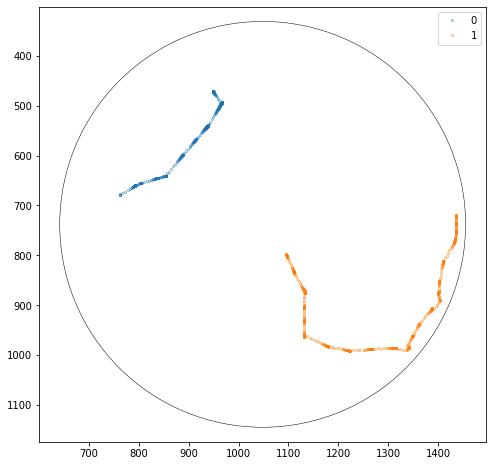

../raw_videos/Pa_Fri_7dpf_GroupB_n5_2020-06-05-094643-0000.avi

        Trial loaded from ../tracking/partial/Pa_Fri_7dpf_GroupB_n5_2020-06-05-094643-0000/trial.pik 


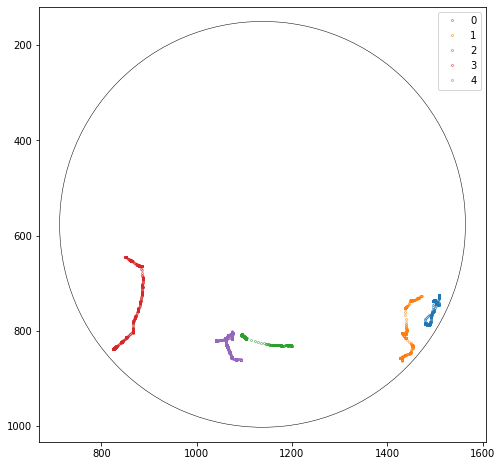

In [21]:
for input_file in input_files:
    
    print(input_file)
    settings = create_settings(input_file)
#     settings.update(tweaks)
    
    trial = Trial()
    trial.load(settings['trial_file'])

    plt.figure(figsize=(8,)*2)
    circle = plt.Circle( (trial.tank.col_c,trial.tank.row_c), trial.tank.r,
                         facecolor='None', edgecolor='k', lw=0.5 )
    plt.gca().add_patch(circle)
    for fish in trial.df.columns.levels[0]:
        x,y,theta,area = trial.df[fish].values.T
        plt.plot(x,y,marker='o',ms=2,mew=0.5,mfc='None',lw=0,label=str(fish))
    plt.axis('equal')
    plt.gca().yaxis.set_inverted(True)
    plt.legend()
    plt.show()

# display(tracker.df.loc[:,(slice(None),['x_px','y_px'])])

In [ ]:
help(plt.Circle)